# Multitaper TFR Analysis: SLCH002

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy
import joblib

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
## Prep paths ##

subject = 'SLCH002'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

# load
last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")

# get good epochs (for behavioral data only)
# good_epochs = [i for i,x in enumerate(last_away_ecpohs.get_annotations_per_epoch()) if not x]

# pull out the neural data
# last_away_df = last_away_ecpohs.get_data()

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events.fif ...


/tmp/ipykernel_6230/350531870.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")


    Found the data of interest:
        t =   -7000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events-1.fif ...
    Found the data of interest:
        t =   -7000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events-2.fif ...
    Found the data of interest:
        t =   -7000.00 ...    7000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
0 bad epochs dropped
0 bad epochs dropped
Not setting metadata
223 matching events found
No baseline correction applied
0 projection items activated


In [4]:
last_away_ecpohs.info

<Info | 11 non-empty values
 bads: []
 ch_names: STI, A1-A2, A2-A3, A3-A4, A4-A5, A5-A6, A6-A7, A7-A8, A8-A9, ...
 chs: 1 Stimulus, 164 sEEG
 custom_ref_applied: True
 dig: 0 items
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 165
 projs: []
 sfreq: 2000.0 Hz
>

In [5]:
## Dictionary of electrode locations ##

# i3', 'i4', 'i5', 'i6', 'i7', 'K2', 'K3', 'K4', 'K5', 'K6', 'J4', 'J5', 'J6'],

ROIs = {
    'hc'     :['K2', 'K3', 'K4', 'K5', 'K6', 'J4', 'J5', 'J6'],
    'ofc'    :['A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16'],
    'amyg'   :['i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7'],
    'insula' :[],
    'cing'   :['A1', 'A2', 'A3', 'A4']
}

hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = []               
insula_list = []
insula_names = []            
cing_list = []
cing_names = []               
pairs_long_name = [ch.split('-') for ch in last_away_ecpohs.info['ch_names']]
bidx = len(last_away_ecpohs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

for ix in range(1, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        
# hc_list_test = hc_list.pop(1)

In [6]:
def MM_compute_TFR(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    #TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,average=False,n_jobs = 2)
    TFR = mne.time_frequency.tfr_multitaper(epochs,freqs,n_cycles,time_bandwidth,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    TFR.data = np.log(TFR.data)
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        bstd = TFR.data[:,:,:,bix].std(axis=(0,3),keepdims=True)
        TFR.data = (TFR.data - bmean) / bstd
    return TFR

### Hippocampus

In [7]:
last_away_ecpohs_hc = last_away_ecpohs.copy().pick_channels(hc_list)

In [8]:
last_away_ecpohs_hc= last_away_ecpohs_hc.resample(1000)

In [10]:
TFR = []

freqs = np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,24,27,30,35,
                  40,45,50,55,60,70,80,90,100,110,120,130,140,150])
bwidth = np.array([0.5,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,3,3,3,5,5,
                   5,5,5,5,10,10,10,10,10,10,10,10,10])
time_bandwidth = 2
n_cycles = freqs * time_bandwidth / bwidth
TFR = MM_compute_TFR(last_away_ecpohs_hc,freqs,n_cycles,baseline = (-5,5), zscore=True,time_bandwidth=time_bandwidth)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:   15.6s remaining:   19.5s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:   17.8s remaining:    8.9s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:   21.1s finished


Not setting metadata
log transforming
z-scoring to baseline


In [11]:
TFR

<EpochsTFR | time : [-7.000000, 6.999000], freq : [0.500000, 150.000000], epochs : 223, channels : 9, ~7.54 GB>

In [12]:
TFR.crop(tmin = -5, tmax = 5)

<EpochsTFR | time : [-5.000000, 5.000000], freq : [0.500000, 150.000000], epochs : 223, channels : 9, ~5.38 GB>

No baseline correction applied


/tmp/ipykernel_6012/2424602493.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  im[0].show()


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


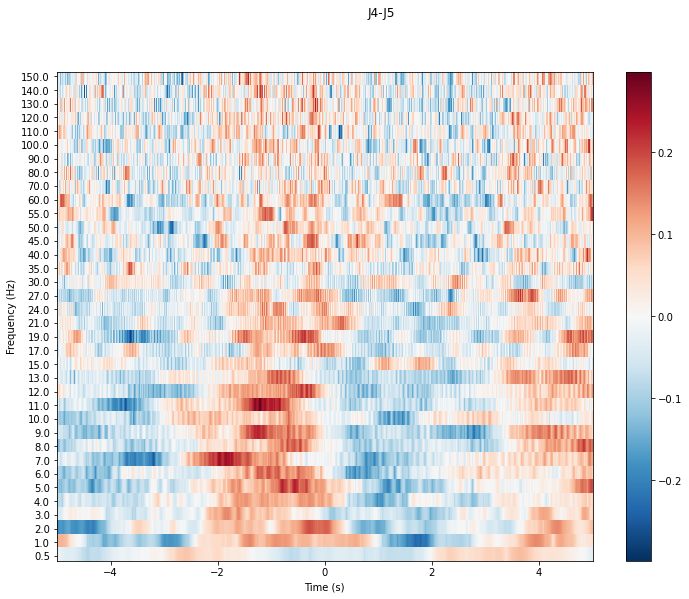

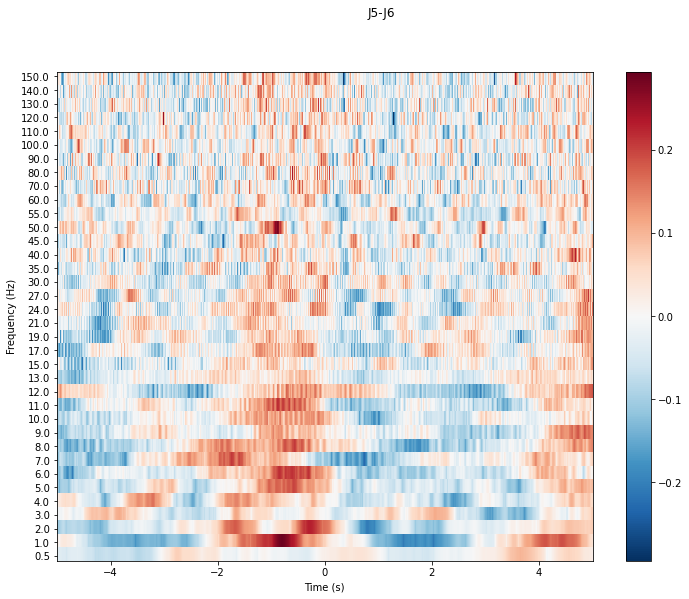

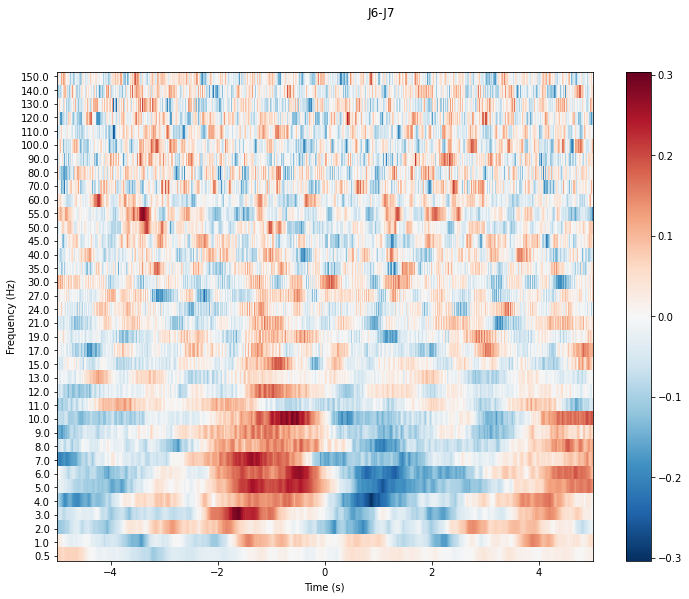

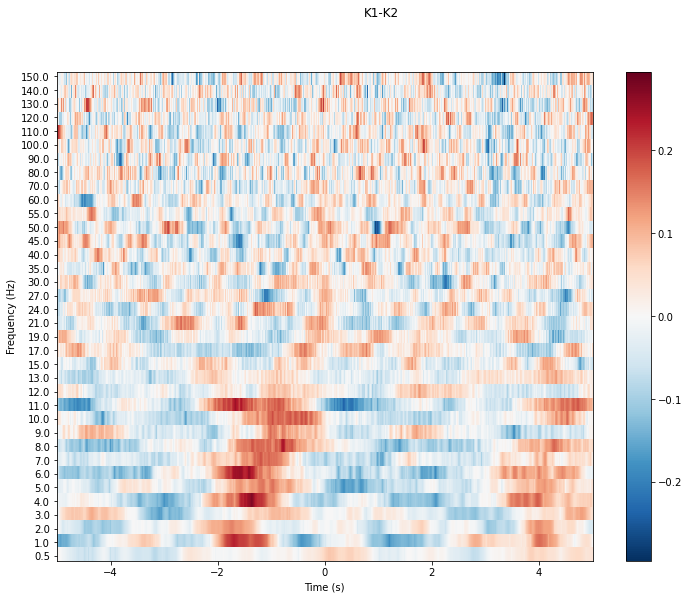

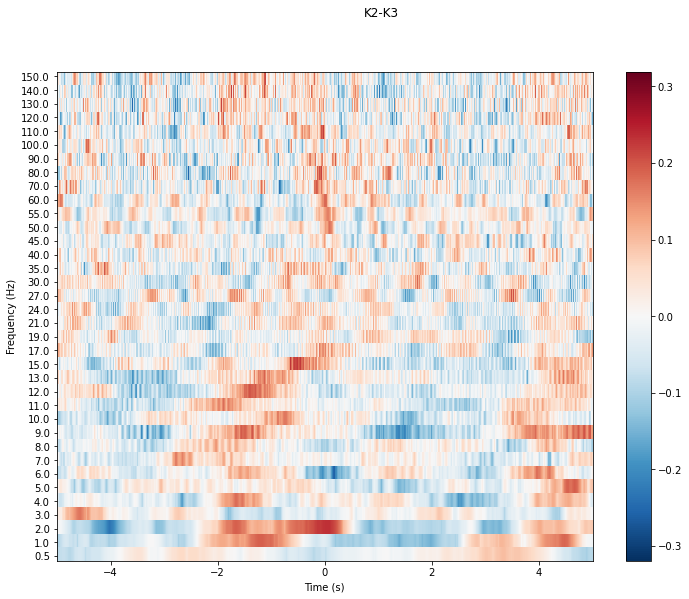

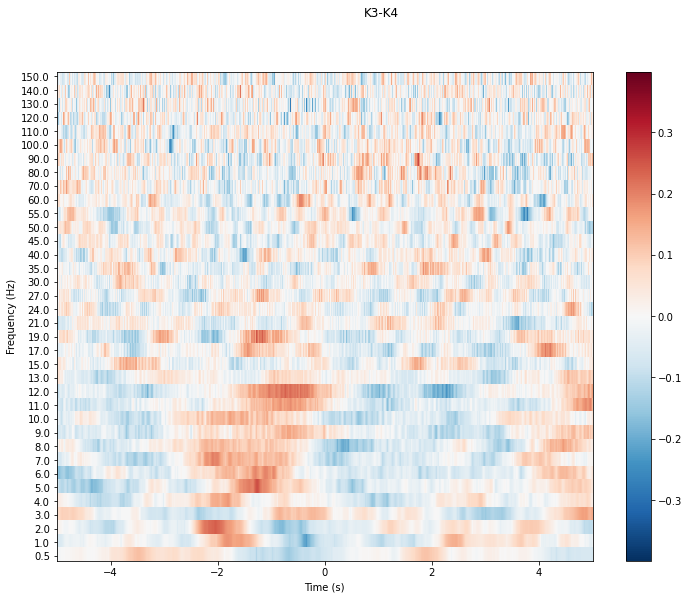

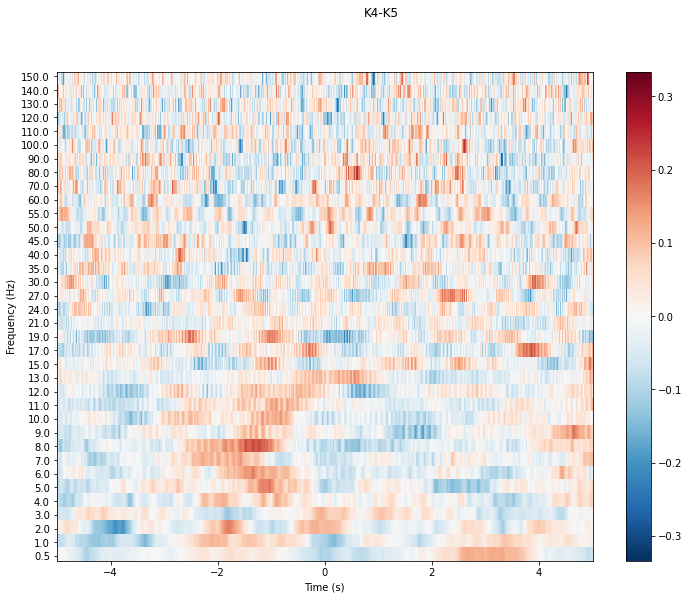

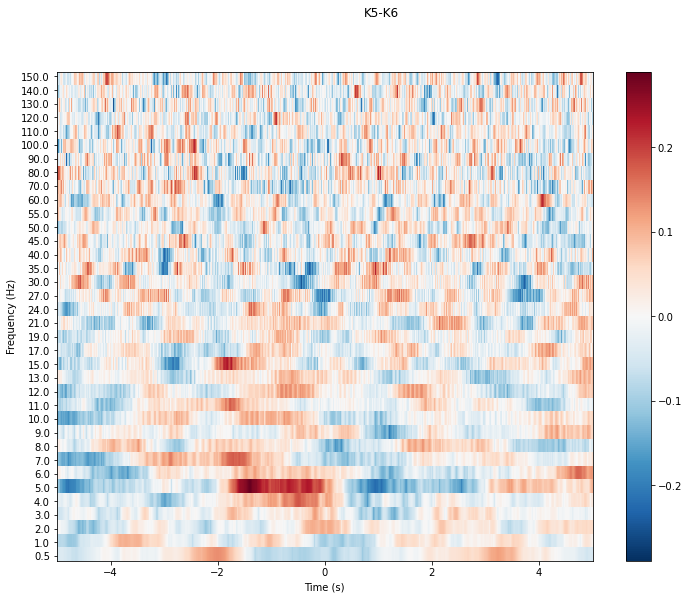

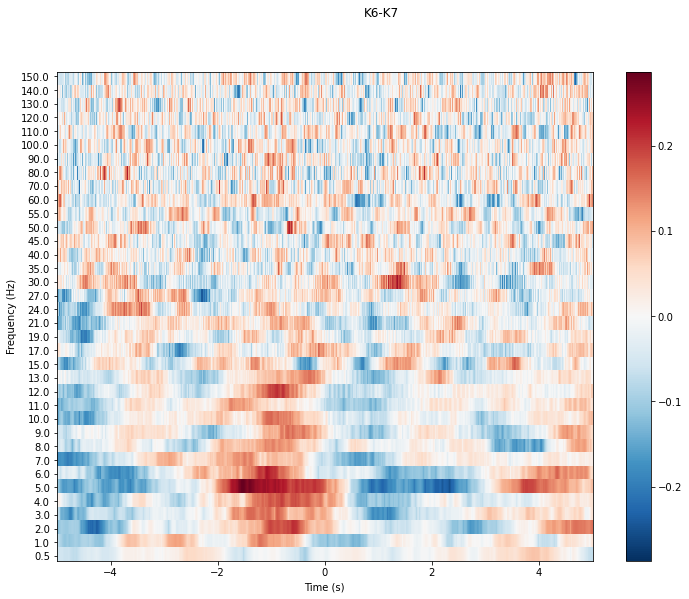

In [13]:
plt.rcParams['figure.figsize'] = [12, 9]

for ch in TFR.ch_names:
        #print(e, ch)
    im = TFR.average().plot(picks=ch,baseline=None,title = ch, show=False)
    i = plt.gca()
    i.set_yticks(np.linspace(np.min(TFR.freqs),np.max(TFR.freqs),len(TFR.freqs)))
    i.set_yticklabels(TFR.freqs)
    im[0].show()

## OFC

In [7]:
last_away_ecpohs_roi = last_away_ecpohs.copy().pick_channels(ofc_list)

In [8]:
ofc_list
toi = 5

In [9]:
last_away_ecpohs_roi = last_away_ecpohs_roi.resample(1000)

In [10]:
TFR = []

freqs = np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,24,27,30,35,
                  40,45,50,55,60,70,80,90,100,110,120,130,140,150])
bwidth = np.array([0.5,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,3,3,3,5,5,
                   5,5,5,5,10,10,10,10,10,10,10,10,10])
time_bandwidth = 2
n_cycles = freqs * time_bandwidth / bwidth
TFR = MM_compute_TFR(last_away_ecpohs_roi,freqs,n_cycles,baseline = (-1*toi,toi), zscore=True,time_bandwidth=time_bandwidth)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  11 | elapsed:   20.3s remaining:   11.6s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:   24.7s finished


Not setting metadata
log transforming
z-scoring to baseline


In [11]:
TFR

<EpochsTFR | time : [-7.000000, 6.999000], freq : [0.500000, 150.000000], epochs : 223, channels : 11, ~9.21 GB>

In [12]:
TFR.crop(tmin = -1*toi, tmax = toi)

<EpochsTFR | time : [-5.000000, 5.000000], freq : [0.500000, 150.000000], epochs : 223, channels : 11, ~6.58 GB>

No baseline correction applied


/tmp/ipykernel_6230/2424602493.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  im[0].show()


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


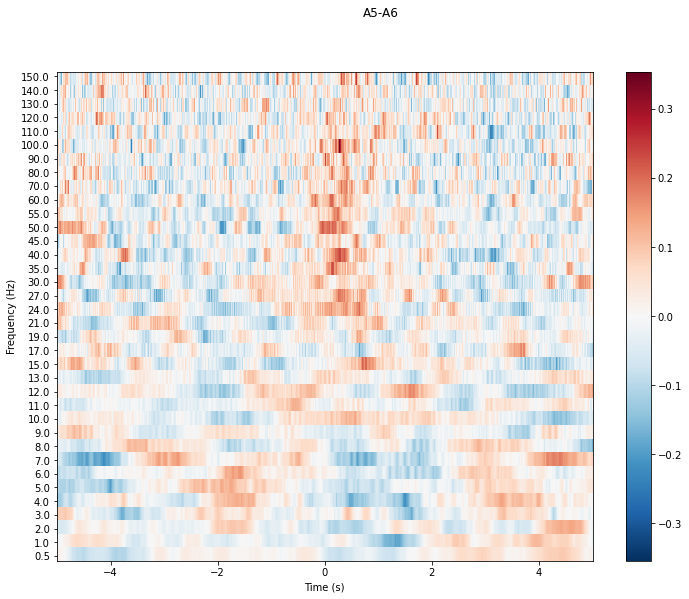

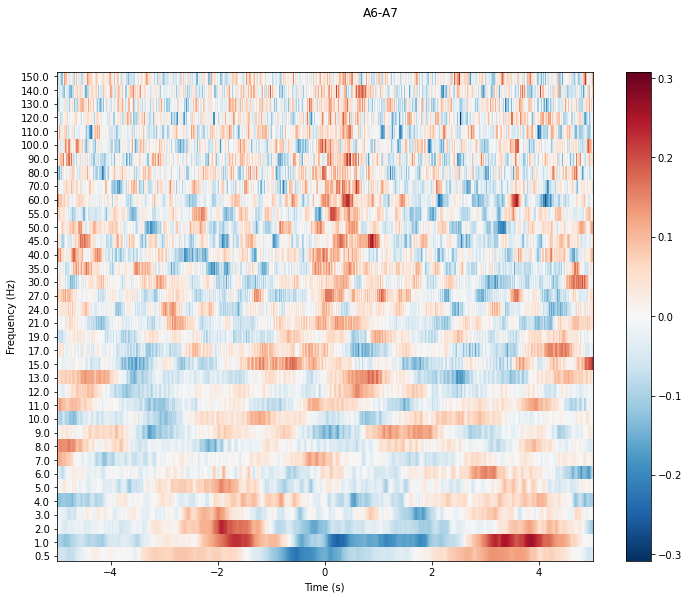

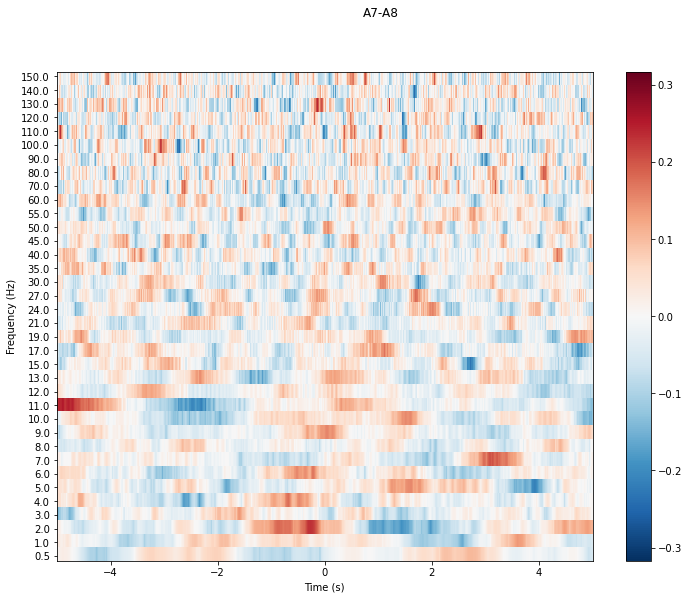

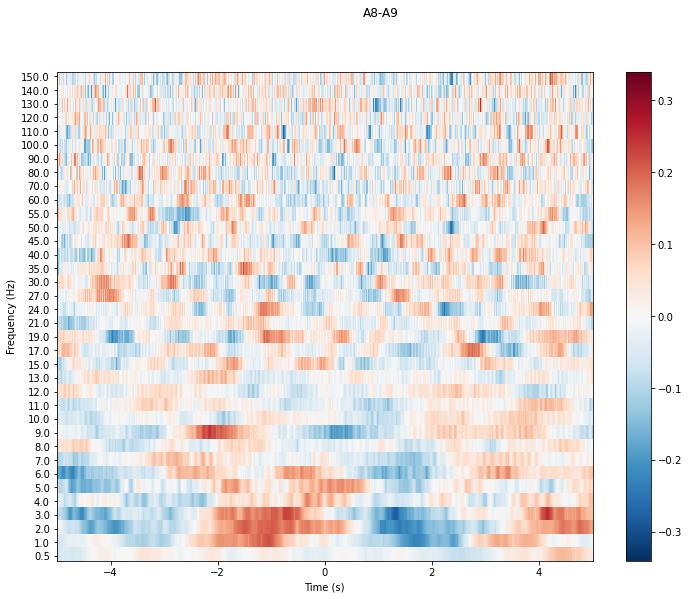

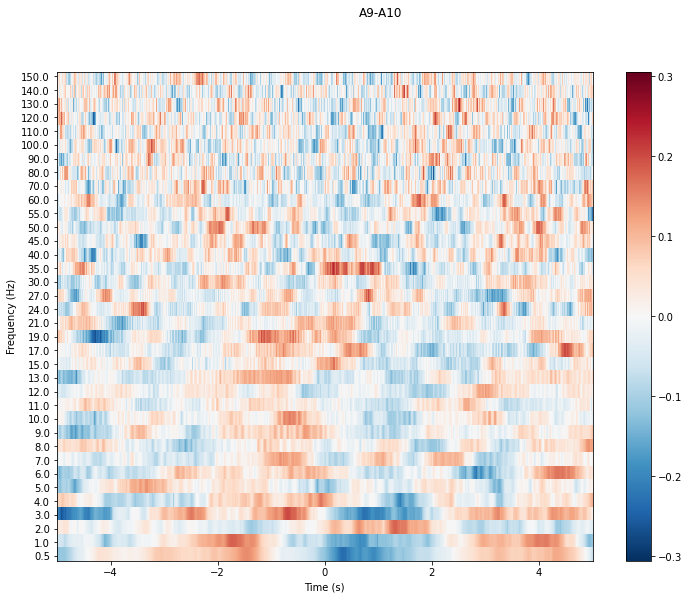

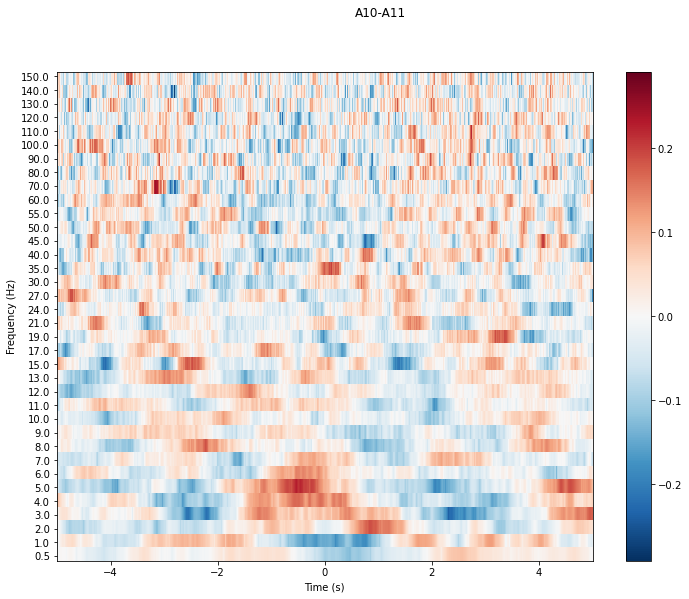

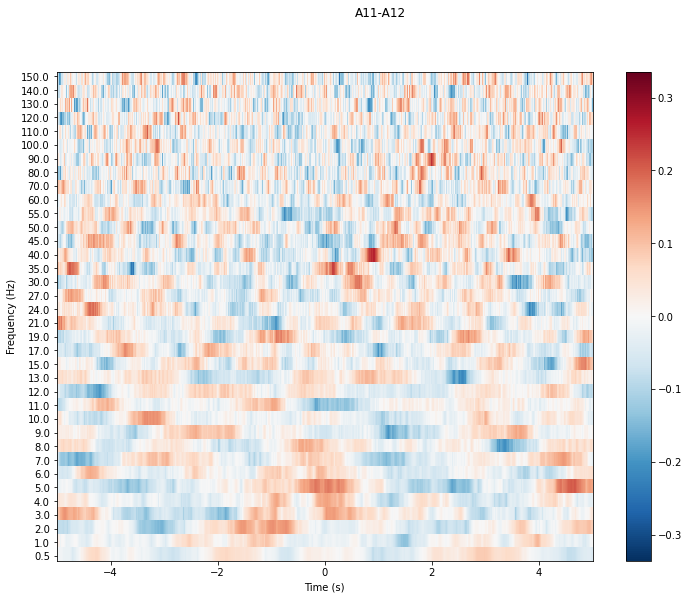

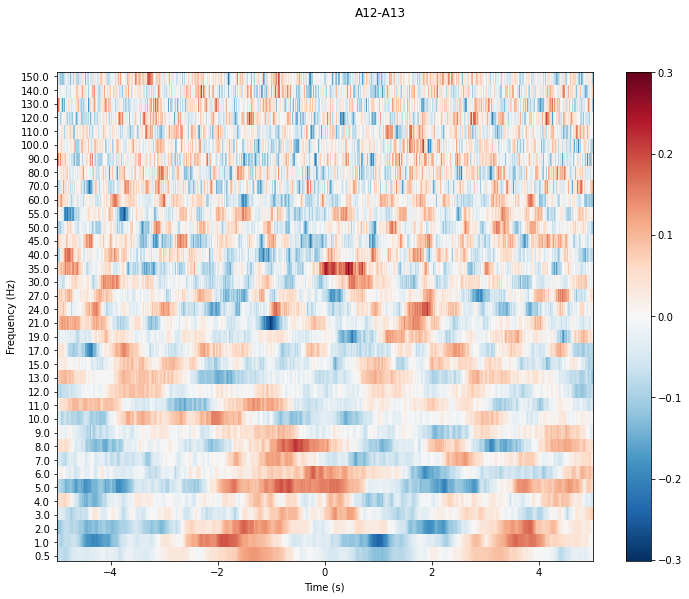

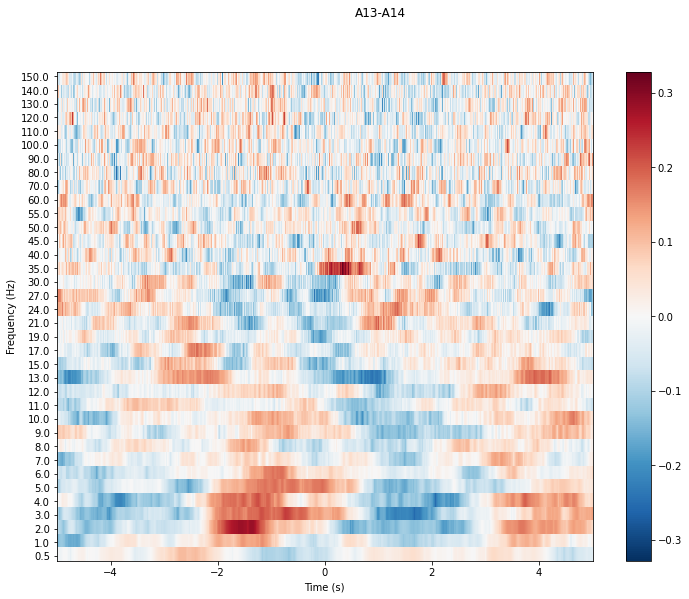

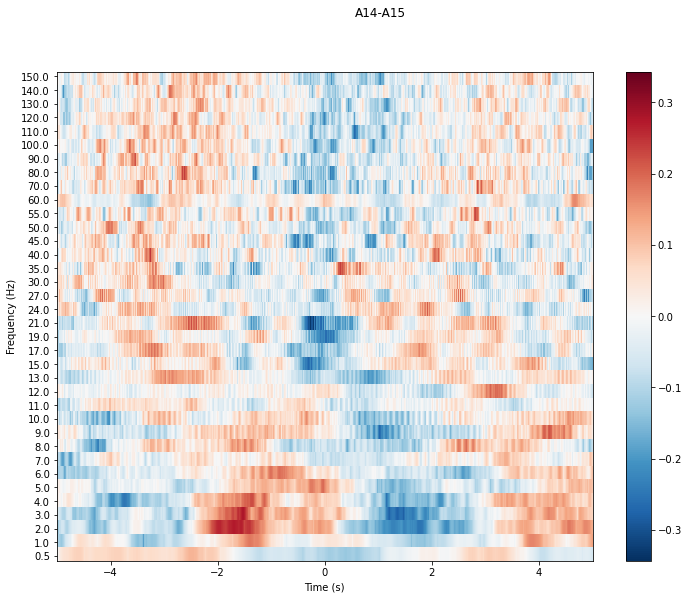

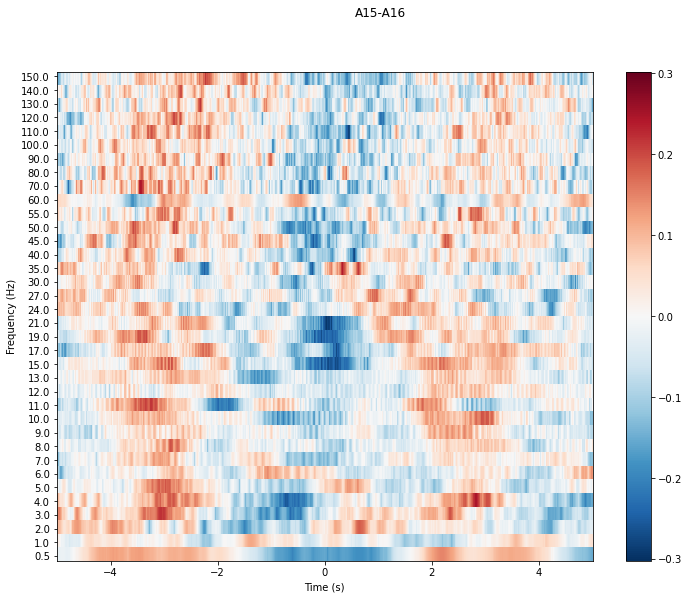

In [13]:
plt.rcParams['figure.figsize'] = [12, 9]

for ch in TFR.ch_names:
        #print(e, ch)
    im = TFR.average().plot(picks=ch,baseline=None,title = ch, show=False)
    i = plt.gca()
    i.set_yticks(np.linspace(np.min(TFR.freqs),np.max(TFR.freqs),len(TFR.freqs)))
    i.set_yticklabels(TFR.freqs)
    im[0].show()

## Amygdala

In [14]:
last_away_ecpohs_roi = last_away_ecpohs.copy().pick_channels(amyg_list)

In [15]:
last_away_ecpohs_roi = last_away_ecpohs_roi.resample(1000)

In [18]:
TFR = []

freqs = np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,24,27,30,35,
                  40,45,50,55,60,70,80,90,100,110,120,130,140,150])
bwidth = np.array([0.5,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,3,3,3,5,5,
                   5,5,5,5,10,10,10,10,10,10,10,10,10])
time_bandwidth = 2
n_cycles = freqs * time_bandwidth / bwidth
TFR = MM_compute_TFR(last_away_ecpohs_roi,freqs,n_cycles,baseline = (-1*toi,toi), zscore=True,time_bandwidth=time_bandwidth)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.1s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   11.3s finished


Not setting metadata
log transforming
z-scoring to baseline


In [19]:
TFR

<EpochsTFR | time : [-7.000000, 6.999000], freq : [0.500000, 150.000000], epochs : 223, channels : 5, ~4.19 GB>

In [20]:
TFR.crop(tmin = -1 * toi, tmax = toi)

<EpochsTFR | time : [-5.000000, 5.000000], freq : [0.500000, 150.000000], epochs : 223, channels : 5, ~2.99 GB>

No baseline correction applied


/tmp/ipykernel_6230/2424602493.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  im[0].show()


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


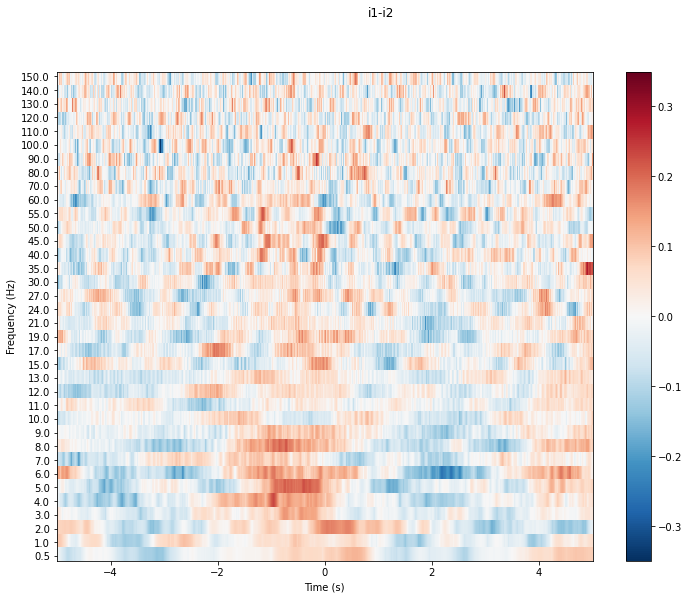

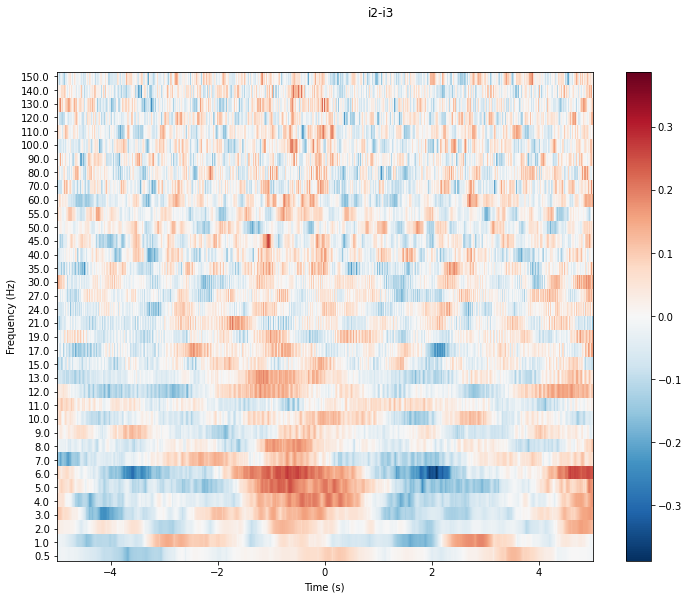

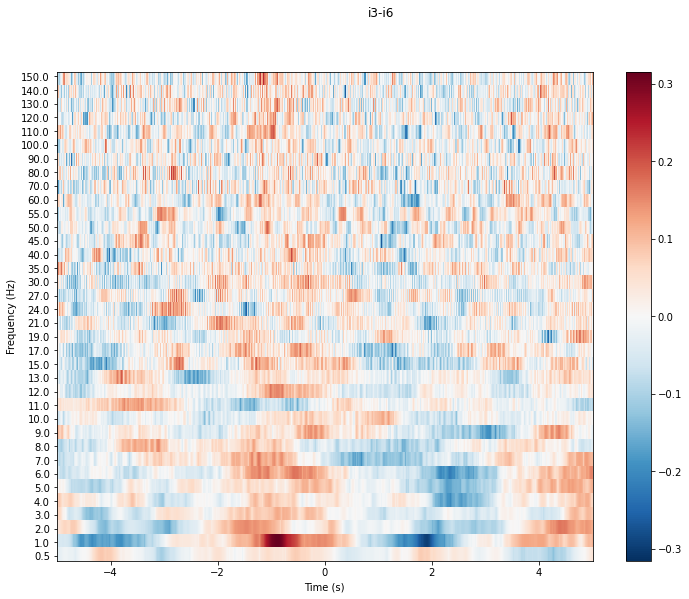

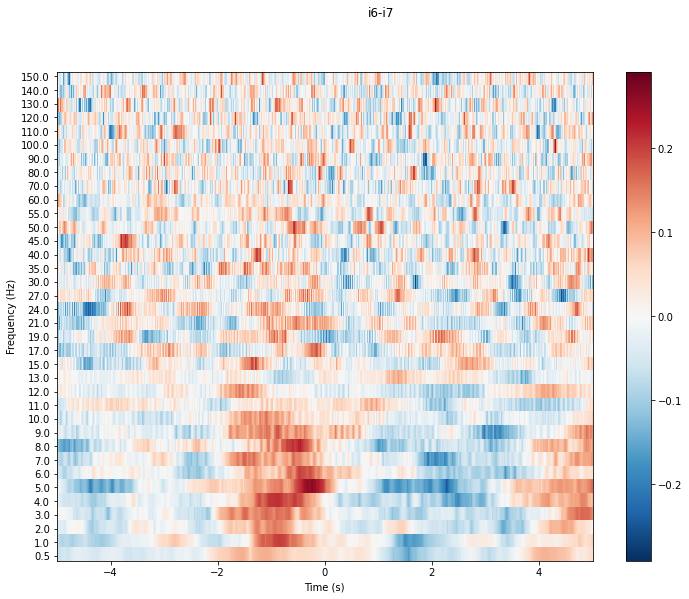

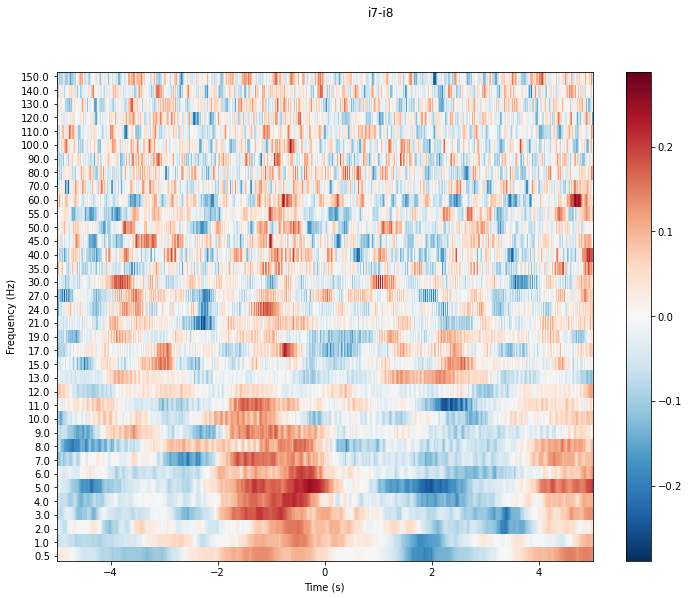

In [21]:
plt.rcParams['figure.figsize'] = [12, 9]

for ch in TFR.ch_names:
        #print(e, ch)
    im = TFR.average().plot(picks=ch,baseline=None,title = ch, show=False)
    i = plt.gca()
    i.set_yticks(np.linspace(np.min(TFR.freqs),np.max(TFR.freqs),len(TFR.freqs)))
    i.set_yticklabels(TFR.freqs)
    im[0].show()

## Cingulate

In [22]:
last_away_ecpohs_roi = last_away_ecpohs.copy().pick_channels(cing_list)

In [23]:
last_away_ecpohs_roi = last_away_ecpohs_roi.resample(1000)

In [24]:
TFR = []

freqs = np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,24,27,30,35,
                  40,45,50,55,60,70,80,90,100,110,120,130,140,150])
bwidth = np.array([0.5,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,3,3,3,5,5,
                   5,5,5,5,10,10,10,10,10,10,10,10,10])
time_bandwidth = 2
n_cycles = freqs * time_bandwidth / bwidth
TFR = MM_compute_TFR(last_away_ecpohs_roi,freqs,n_cycles,baseline = (-1 * toi,toi), zscore=True,time_bandwidth=time_bandwidth)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    7.2s finished


Not setting metadata
log transforming
z-scoring to baseline


In [25]:
TFR

<EpochsTFR | time : [-7.000000, 6.999000], freq : [0.500000, 150.000000], epochs : 223, channels : 3, ~2.51 GB>

In [26]:
TFR.crop(tmin = -1 * toi, tmax = toi)

<EpochsTFR | time : [-5.000000, 5.000000], freq : [0.500000, 150.000000], epochs : 223, channels : 3, ~1.79 GB>

No baseline correction applied
No baseline correction applied


/tmp/ipykernel_6230/2424602493.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  im[0].show()


No baseline correction applied


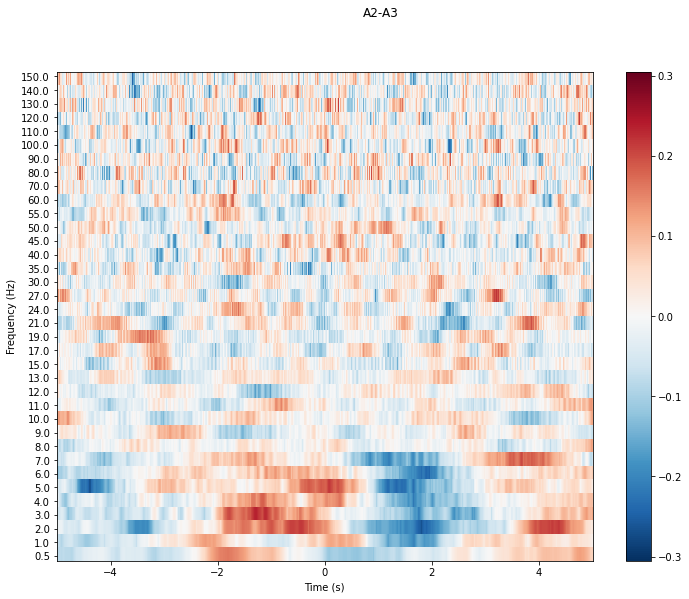

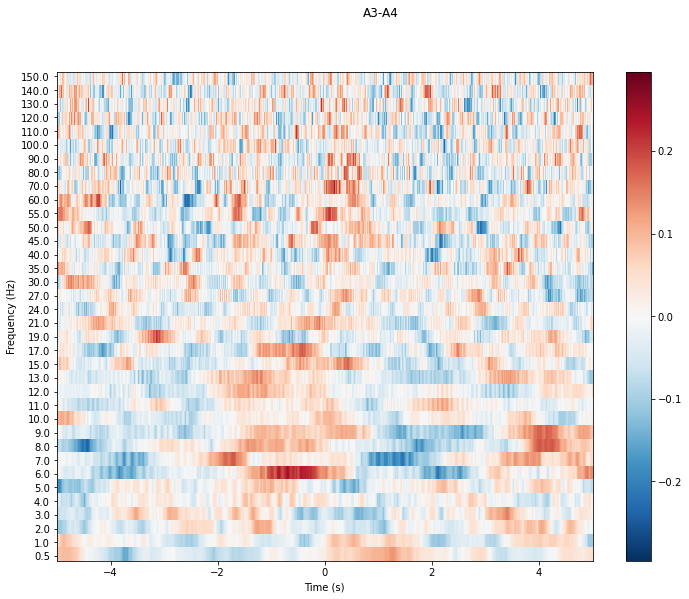

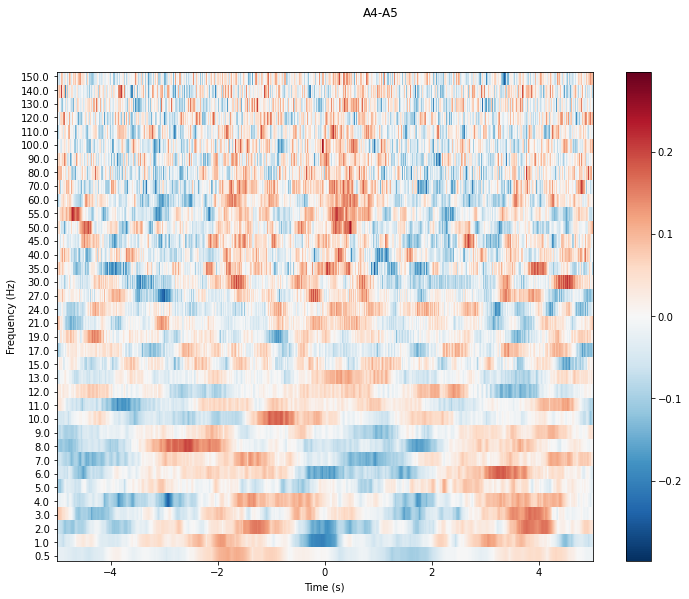

In [27]:
plt.rcParams['figure.figsize'] = [12, 9]

for ch in TFR.ch_names:
        #print(e, ch)
    im = TFR.average().plot(picks=ch,baseline=None,title = ch, show=False)
    i = plt.gca()
    i.set_yticks(np.linspace(np.min(TFR.freqs),np.max(TFR.freqs),len(TFR.freqs)))
    i.set_yticklabels(TFR.freqs)
    im[0].show()

## Insula

In [15]:
last_away_ecpohs_roi = last_away_ecpohs.copy().pick_channels(insula_list)

In [16]:
last_away_ecpohs_roi = last_away_ecpohs_roi.resample(1000)

In [48]:
TFR = []

freqs = np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,24,27,30,35,
                  40,45,50,55,60,70,80,90,100,110,120,130,140,150])
bwidth = np.array([0.5,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,3,3,3,5,5,
                   5,5,5,5,10,10,10,10,10,10,10,10,10])
time_bandwidth = 2
n_cycles = freqs * time_bandwidth / bwidth
TFR = MM_compute_TFR(last_away_ecpohs_roi,freqs,n_cycles,baseline = (-2,2), zscore=True,time_bandwidth=time_bandwidth)

In [47]:
TFR

In [46]:
TFR.crop(tmin = -2, tmax = 2)

In [45]:
plt.rcParams['figure.figsize'] = [12, 9]

for ch in TFR.ch_names:
        #print(e, ch)
    im = TFR.average().plot(picks=ch,baseline=None,title = ch, show=False)
    i = plt.gca()
    i.set_yticks(np.linspace(np.min(TFR.freqs),np.max(TFR.freqs),len(TFR.freqs)))
    i.set_yticklabels(TFR.freqs)
    im[0].show()